In [1]:
import pandas as pd
import tensorflow as tf
import csv
import numpy as np
import matplotlib.pyplot as plt

2021-09-19 12:29:07.104692: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-19 12:29:07.104718: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<h3>Importação dos Dados</h3>

In [2]:
#source_file = '../../Data/process/patio1_17a19_concilia.csv'
source_file = '../../../Data/Processed/cenario3/dados_cenario3.csv'
df = pd.read_csv(source_file, delimiter=';', index_col=0, parse_dates=['Data'])
df.head(2)

,Longitude,Latitude,Data,Vento_Magnitude
0,-42.75,-14.25,2017-01-01 00:00:00,9.815
1,-42.75,-14.25,2017-01-01 01:00:00,8.735


<h3>Manter apenas o Vento e a Data no Dataframe</h3>

In [3]:
#df = df.drop(['Longitude', 'Latitude','Pressao','Temperatura','DirecaoVento'], axis=1)

output_file = '../../../Data/Processed/cenario3/LMTS.csv'
df.to_csv(output_file, sep=';', encoding='utf-8')

<h3>Função para Geração do Grafico da Serie Temporal</h3>

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

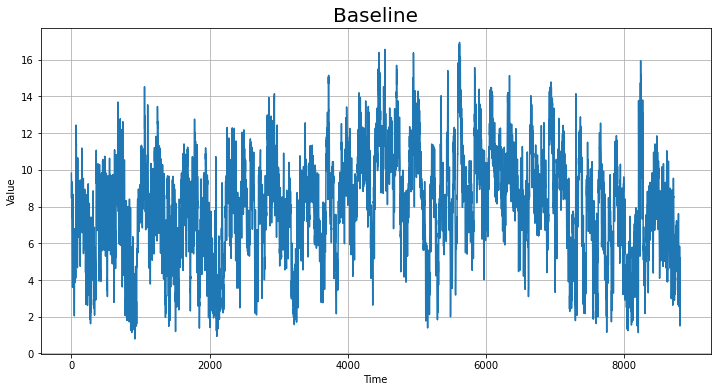

In [9]:
time_step = []
temps = []

with open(output_file) as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    next(reader)
    step=0
    for row in reader:
        temps.append(float(row[4]))
        time_step.append(step)
        step = step + 1

series = np.array(temps)
time = np.array(time_step)

plt.figure(figsize=(12, 6))
plt.title('Baseline', fontsize=20)
plot_series(time, series)

In [10]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [12]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)


model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

2021-09-19 12:34:59.789548: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-19 12:34:59.789568: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-19 12:34:59.789581: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (NB-MLS-UBUNTU): /proc/driver/nvidia/version does not exist
2021-09-19 12:34:59.789730: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


2021-09-19 12:35:00.440701: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
10/10 [==============================] - 4s 159ms/step - loss: 18.1999 - mae: 18.6936
Epoch 2/100
10/10 [==============================] - 2s 147ms/step - loss: 17.4572 - mae: 17.9501
Epoch 3/100
10/10 [==============================] - 2s 156ms/step - loss: 16.3519 - mae: 16.8454
Epoch 4/100
10/10 [==============================] - 2s 146ms/step - loss: 15.0598 - mae: 15.5534
Epoch 5/100
10/10 [==============================] - 2s 151ms/step - loss: 13.6444 - mae: 14.1360
Epoch 6/100
10/10 [==============================] - 2s 149ms/step - loss: 12.1447 - mae: 12.6360
Epoch 7/100
10/10 [==============================] - 2s 150ms/step - loss: 10.5936 - mae: 11.0842
Epoch 8/100
10/10 [==============================] - 2s 154ms/step - loss: 9.0260 - mae: 9.5154
Epoch 9/100
10/10 [==============================] - 2s 151ms/step - loss: 7.5153 - mae: 8.0039
Epoch 10/100
10/10 [==============================] - 2s 172ms/step - loss: 6.1245 - mae: 6.6124
Epoch 11/100
10/10 [=====

(1e-08, 0.0001, 0.0, 60.0)

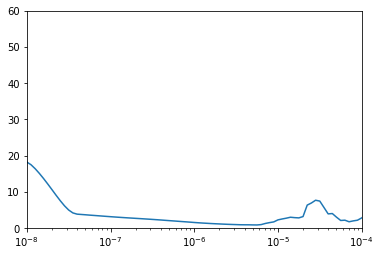

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

/home/marcelo/.local/share/virtualenvs/mod4_redes_neurais-6Ea7GEaz/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/150
25/25 [==============================] - 4s 73ms/step - loss: 10.1884 - mae: 10.6760
Epoch 2/150
25/25 [==============================] - 2s 71ms/step - loss: 2.2337 - mae: 2.7015
Epoch 3/150
25/25 [==============================] - 2s 71ms/step - loss: 2.2034 - mae: 2.6770
Epoch 4/150
25/25 [==============================] - 2s 69ms/step - loss: 2.0622 - mae: 2.5354
Epoch 5/150
25/25 [==============================] - 2s 72ms/step - loss: 1.9297 - mae: 2.4010
Epoch 6/150
25/25 [==============================] - 2s 70ms/step - loss: 1.8539 - mae: 2.3245
Epoch 7/150
25/25 [==============================] - 2s 73ms/step - loss: 1.6878 - mae: 2.1541
Epoch 8/150
25/25 [==============================] - 2s 70ms/step - loss: 1.6124 - mae: 2.0767
Epoch 9/150
25/25 [==============================] - 2s 72ms/step - loss: 1.5628 - mae: 2.0263
Epoch 10/150
25/25 [==============================] - 2s 74ms/step - loss: 1.5171 - mae: 1.9797
Epoch 11/150
25/25 [===========================

In [16]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

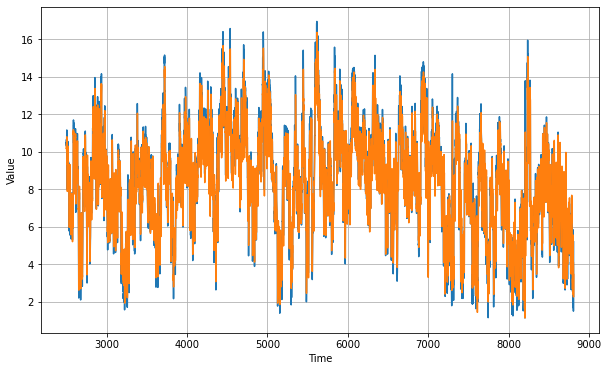

In [17]:
# original data (blue) vs forecasted values (orange)
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)


In [18]:
tf.keras.metrics.mse(x_valid, rnn_forecast).numpy()


0.78661025

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.6694069

In [20]:
print(rnn_forecast)

[10.173326  10.152295  10.225503  ...  3.607779   2.24956    3.4455748]
